This is an example of fitting the time constant via MCMC using the data from June 2017. (the figure then used in the current version of the paper). 
The fit model is compared to the experimental 30mm/s interferogram. 
The 30 mm/s interferogram is then deconvolved using the $\tau$ returned the MCMC fit.
The deconvolved 30mm/s interferogram is then compared to the original 30mm/s interferogram as well as a 10mm/s interferogram.

Mira
10/08/19


In [158]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import seaborn as sns
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit

sns.set_palette("PuBuGn_d",15)
sns.set_style("whitegrid")
#import emcee

# Plotting the 30mm/s blackbody source interferogram

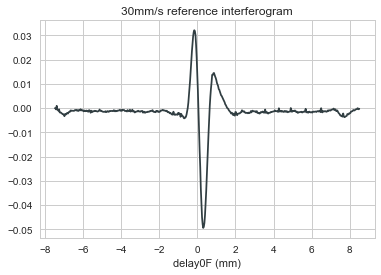

In [281]:
with open('../../data/raw_data/20170615_1729_30mms_reference.pkl', 'rb') as f:
    d = pickle.load(f, encoding='latin1') 
i = 9
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
#print(v)
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0

startpt = int(startpt)
endpt = int(endpt)
F = (d['sig0F']) 
D = F[startpt:endpt]
#D = np.flipud(D)

dd = d['delay0F']
ddd = dd[startpt:endpt]
a = d['delay0F']/v
t = a[startpt:endpt]

pl.title('30mm/s reference interferogram')
pl.xlabel('delay0F (mm)')
pl.plot(ddd,D)
pl.show()

# code version of equation 1 in the paper

In [282]:
#model function convoluted with RC circuit and AC coupling function
def psi1(znot,q,p,T):
    Ns = Nsize
    z = t
    dz = z[2]-z[1]
    znot=0 #hardcoding znot to be zero.
    #dz = z[int(2)]-z[int(1)]
    f = np.linspace(0,int(0.5/dz), int(np.floor(Ns/2)))
    f_full = np.linspace(0,int(0.5/dz), int(np.floor(Ns/2 +1)))
    #original function
    y0=-np.cos(2*np.pi*q*(z-znot))*(np.exp(-((z-znot)**2)/(2*p**2)))/(np.sqrt(2*np.pi)*p)
    yf0=np.fft.rfft(y0)
    K_det =(1/(1+(1j*2*np.pi*f_full*T))) #kernel from detector
    K_cc =(2*np.pi*f_full*.559)/(1 + (1j*2*np.pi*.559)) #kernel from AC coupling
    K_f = np.multiply(K_det,K_cc)
    y1=np.fft.irfft(yf0*K_f*2*np.pi)
    return t,y1
#znot = 0.012, q = 8.57718120805, p = .04

# plugging in the PEAKS gotten from the MCMC fit (shown in notebook TimeConstant3) and comparing the resulting convolved interferogram model to the experimental 30mm/s interferogram

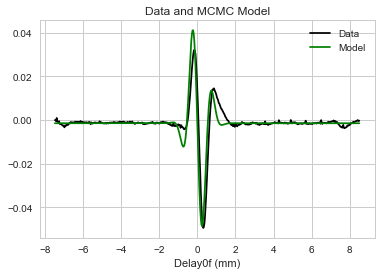

In [288]:
#plugging in the PEAKS gotten from the MCMC 
pl.plot(ddd,D, label = 'Data', color = 'black')
x,Modelf = psi1( 0.000157881588507,   22.5,   0.01399,   .00173) #z,q,p,T,a = .000014, y-shift = .00148

pl.plot(ddd,Modelf*.000014-.00148, label = 'Model', color = 'green')
pl.title('Data and MCMC Model')
pl.xlabel('Delay0f (mm)')
pl.legend()
pl.show()

# Using the numbers from the MCMC that create the plot above, deconvolving the experimental 30mm/s interferogram

The amplitudes have been adjusted to make the differences more clear.

/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


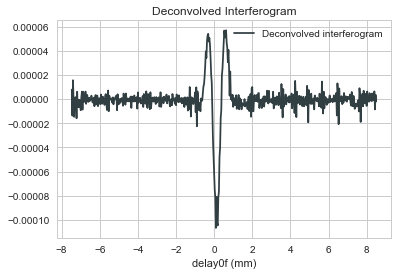

In [290]:
# deconvolving the experiment
A = F[startpt:endpt]#np.hanning(Nsize)*F[startpt:endpt]
S = np.fft.rfft(A)
s = S[:-1]
u = np.abs(s)
dNu = 1/(Nsize*dx)
Nu = dNu*np.arange(Nsize/2)
NuFull = dNu*np.arange((Nsize/2) + 1)
center = (300*(Nu[0] + Nu[-1]))/2
top = max(np.abs(s))
tau = .00173#ms
k_v = 1/((1/tau)+1j*2*np.pi*300*NuFull)
            
            
n = 3 #greater number filters out more high frequencies
sig = n/(tau*(2*np.pi)) 
f = (1/(sig*np.sqrt(np.pi)))*np.exp(-(NuFull**2)/(sig**2)) #gaussian
B = f*np.fft.rfft(A)/k_v*tau  #fourier transform of interferogram/kernel
c = np.fft.irfft(B) #inverse fourier transform of deconvolved spectrum (deconvolved interferogram)
            
# normalize gaussian to get rid of noise (divide by integral of itself) (in B)
            
g = (np.abs(np.fft.rfft(c))/k_v*tau)[:2**7] #CHANGE depending on number of data points
L=np.sum(g) #integral of spectrum
            
xint, yint = t, (1/L)*c
xspec, yspec = 300*NuFull, np.abs(np.fft.rfft(c))/k_v*tau
yspecnoabs = np.fft.rfft(c)/k_v*tau

pl.plot(ddd,yint, label = 'Deconvolved interferogram')
pl.title('Deconvolved Interferogram')
#pl.plot(xspec,yspec, label = 'Deconvolved spectrum')
#pl.plot(300*NuFull,np.abs(S)*.00575, label = 'original spectrum', color = 'green')
#pl.title('Deconvolved spectrum')
pl.xlabel('delay0f (mm)')
pl.legend()
pl.show()

# a 10mm/s reference which should show little time constant influence and be symmetrical about 0.0 delay0f, and be what the 30mm/s reference should deconvolve to.

10


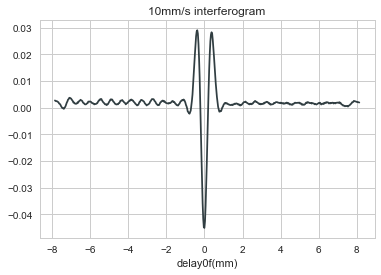

In [330]:
#20170615_1729_30mms_reference.pkl
with open('../../data/raw_data/20160921_1724_20160921_10mms_new_fts_all_band.pkl', 'rb') as f:
    d = pickle.load(f, encoding='latin1') 
i = 9
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
#print(v)
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0

startpt = int(startpt)
endpt = int(endpt)
F = (d['sig0F']) 
D2 = F[startpt:endpt]
#D = np.flipud(D)

dd2 = d['delay0F']
ddd2 = dd2[startpt:endpt]
a = d['delay0F']/v
t2 = a[startpt:endpt]
pl.plot(ddd2,D2)
#pl.plot(ddd,D)
pl.title('10mm/s interferogram')
pl.xlabel('delay0f(mm)')
pl.show()

# comparison of all 3: with amplitudes adjusted. (and the 'slow mirror' shifted in the y direction to have a mean of zero at the ends).

/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


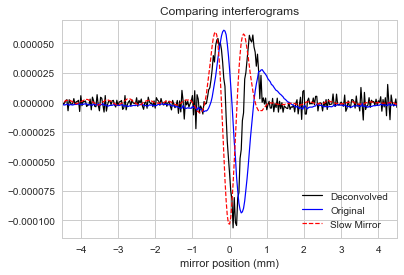

In [328]:
#t3 = np.linspace(-.055,.075,212)
pl.plot(ddd[90:-90],yint[90:-90], label = 'Deconvolved',color = 'black',linewidth=1.2)
pl.plot(ddd[90:-90],D[90:-90]*.0019,label = 'Original', color = 'blue',linewidth=1.2)
pl.plot(ddd2[90:-90],D2[90:-90]*.0022-0.00195*.0022,linestyle = '--',label = 'Slow Mirror',color = 'r',linewidth=1.2)
pl.title('Comparing interferograms')
pl.legend(loc = 'lower right')
#pl.savefig('DeconvolvedInterferograms.png',dpi = 1000)
pl.xlabel('mirror position (mm)')
pl.xlim(-4.5,4.5)
pl.show()